# DDPM for MNIST 

In [225]:
import torch 
import numpy as np
import tensorboard as tb 
import matplotlib.pyplot as plt
from torch import optim, nn, utils, Tensor

import lightning as L
from torchvision import datasets, transforms

from pytorch_lightning.loggers import TensorBoardLogger
from typing import Callable, Optional


In [226]:
# Setting a seed and setting the device


seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA available — deterministic settings applied.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available — seed set, but determinism not guaranteed.")
else:
    device = torch.device("cpu")
    print("CPU-only — seed set.")

print("Device = ", device)

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)




#device = torch.device("cpu")

MPS is available — seed set, but determinism not guaranteed.
Device =  mps


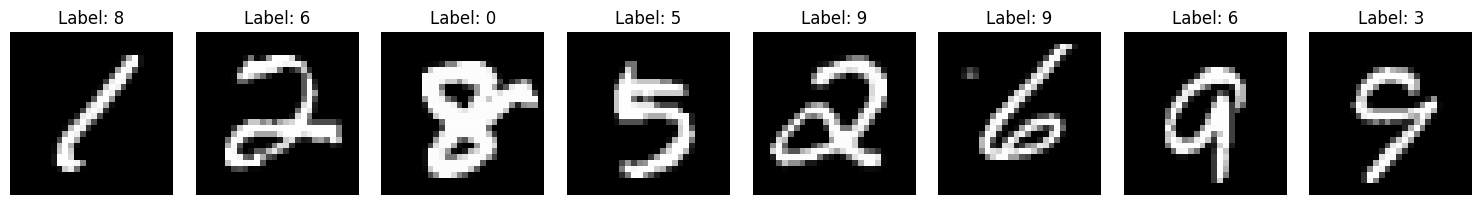

In [227]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=8, shuffle=True)

images,_ = next(iter(train_loader))
fig, axs = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    axs[i].imshow(images[i][0], cmap='gray')
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

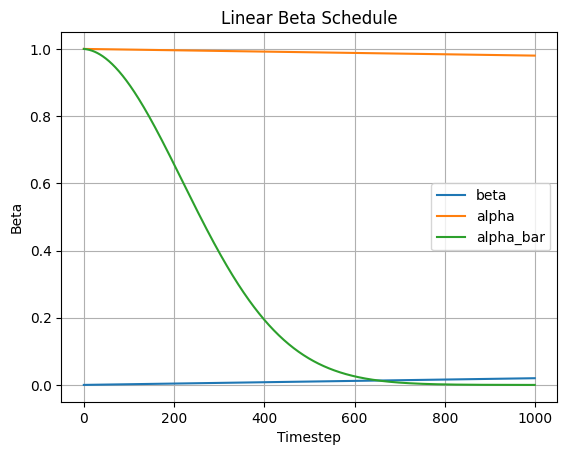

In [228]:

def linear_beta_scheduler(timesteps: int, start: float = 1e-4, end: float = 0.02):
    return torch.linspace(start, end, timesteps, device = device)

timesteps = 1000
start = 0.0001
end = 0.02
beta =  linear_beta_scheduler(timesteps,start = start, end = end)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
plt.plot(beta.cpu().numpy(), label = "beta")
plt.plot(alpha.cpu().numpy(), label = "alpha")
plt.plot(alpha_bar.cpu().numpy(), label = "alpha_bar")
plt.title("Linear Beta Schedule")
plt.xlabel("Timestep")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.show()

In [229]:
def noising(t_index : torch.Tensor, x_0: torch.Tensor, alpha_bar: torch.Tensor, seed : int = None, noise : torch.tensor = None) -> torch.Tensor:
    """ 
    This function defines the noising process from a batch tensor of x_0
    x_0 is supposed to be of size batch_size x x_size
    t is supposed to be of size batch_size
    Attention to t_index, tensor are indexed with a shift of -1 in comparaison to timesteps. 
    If we pass the indexes we should just perform alpha_bar[t_index], if we pass time steps we should do alpha_bar[t_index -1]
    """
    
    if noise is None:
        noise = torch.randn_like(x_0, device=x_0.device)

    alpha_bar_t = alpha_bar[t_index].view(-1, *[1] * (x_0.dim() - 1))
        

    return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise    


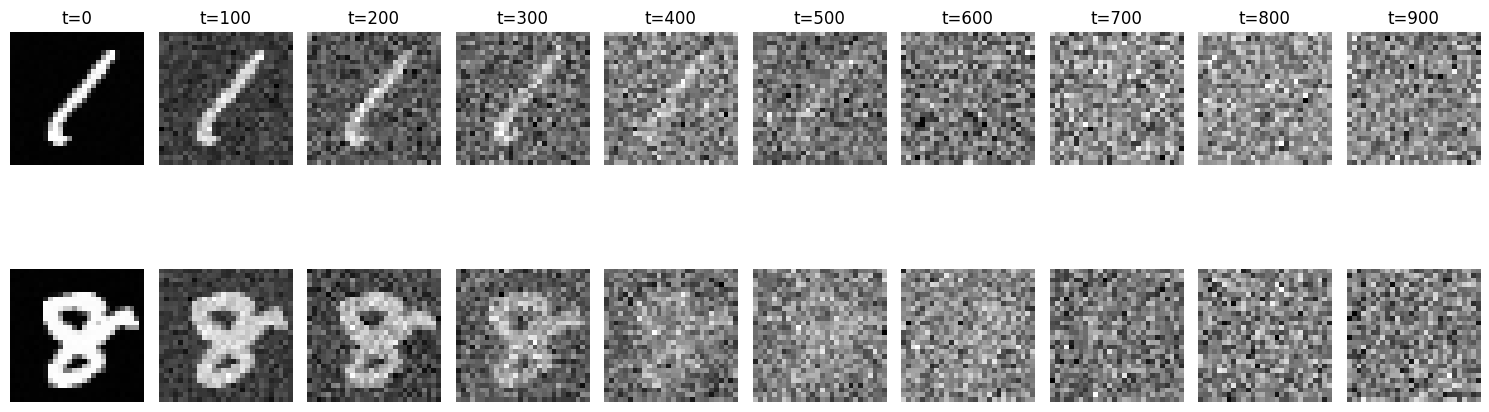

In [230]:
image1 = images[0].unsqueeze(0).to(device)
image2 = images[2].unsqueeze(0).to(device)

images1 = []
images2 = []
step = 100
for t in range(0, timesteps, step):
    t_index = torch.tensor(t)
    noisy1 = noising(t_index=t_index, x_0=image1, alpha_bar=alpha_bar)
    noisy2 = noising(t_index=t_index, x_0=image2, alpha_bar=alpha_bar)
    images1.append(noisy1.squeeze(0).squeeze(0).cpu().numpy())
    images2.append(noisy2.squeeze(0).squeeze(0).cpu().numpy())

fig, axes = plt.subplots(2, len(images1), figsize=(15, 6))
for i in range(len(images1)):
    axes[0, i].imshow(images1[i], cmap='gray')
    axes[0, i].set_title(f"t={i * step}")
    axes[0, i].axis('off')

    axes[1, i].imshow(images2[i], cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel("Image 1", fontsize=12)
axes[1, 0].set_ylabel("Image 2", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:


class SimpleScoreModel(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, time_emb_dim=32, time_dim=1000):
        super().__init__()

        self.time_embedding = nn.Embedding(time_dim, time_emb_dim)

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, 32),
            nn.ReLU()
        )   

    def forward(self, x, t):
        time_emb = self.time_embedding(t) 
        time_emb = self.time_mlp(time_emb)
        time_emb = time_emb.view(time_emb.size(0), time_emb.size(1), 1, 1) 

        x = self.act1(self.norm1(self.conv1(x)))
        x = x + time_emb 

        x = self.act2(self.norm2(self.conv2(x)))
        
        x = self.conv3(x)
        
        return x


channels = 1
image_size = 28
 
time_emb_dim = 64

model = SimpleScoreModel(input_channels=channels, output_channels=channels, time_emb_dim=time_emb_dim, time_dim=timesteps)

In [232]:
def generate_with_noiser(size: int = 100, seed: int = None, x_t: torch.Tensor = None, 
                        noiser: Callable = None, beta: torch.Tensor = None, alpha_bar : torch.Tensor = None,
                        timesteps : int = None, alpha : torch.Tensor = None, normalized : bool = False, 
                        mean : float = None, std : float = None, device: torch.device = 'cuda') -> torch.Tensor:
    """
    Generate a sample using the noiser instructions from arXiv:2006.11239v2
    
    Args:
        size (int): Number of images to generate.
        seed (int): Random seed for reproducibility.
        x_t (torch.Tensor): Starting noise tensor (if None, random noise is used).
        noiser (Callable): The noiser function or model.
        beta (torch.Tensor): Beta schedule for diffusion.
        alpha_bar (torch.Tensor): Alpha bar schedule for diffusion.
        timesteps (int): Number of diffusion timesteps.
        alpha (torch.Tensor): Alpha schedule for diffusion.
        normalized (bool): Whether to normalize the output back to the image range.
        mean (float): Mean to normalize back the image.
        std (float): Standard deviation to normalize back the image.
        device (torch.device): The device to run the model on.
    
    Returns:
        torch.Tensor: Generated sample.
    """
    
    if seed is not None:
        torch.manual_seed(seed)
    
    if x_t is None:
        x_t = torch.randn(size, 1, 28, 28, device=device)
    
    alpha_bar_minus = nn.functional.pad(
            alpha_bar[:-1], (1, 0), value=1.0)
    sigma = torch.sqrt(beta * (1.0 - alpha_bar_minus) / (1.0 - alpha_bar))

    if isinstance(noiser, nn.Module):
        noiser.eval()
    
    with torch.no_grad():
        for t in reversed(range(timesteps)):
            t_index = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)

            noise = noiser(x_t, t_index)
            
            z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)

            coef = (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t])
            
            x_t = (
                (1 / torch.sqrt(alpha[t])) * (x_t - coef * noise)
                + sigma[t] * z
            )
    
    if normalized:
        return x_t * std + mean
    else:
        return x_t

In [ ]:
def train(model, dataloader, timesteps, alpha_bar, noising, epochs=500, lr=1e-4, device='cuda'):
    
    """
    This function simply implements the training of the noiser model
    
    Training using the instructions given by arXiv:2006.11239v2
    
    """
    
    
    
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for images,_ in dataloader:
            images = images.to(device)
            noise = torch.randn_like(images)
            t = torch.randint(timesteps, size=(images.shape[0],), device=images.device)
            noised = noising(t_index=t, x_0=images, alpha_bar=alpha_bar, noise=noise)
            pred_noise = model(noised, t)
            loss = nn.functional.mse_loss(pred_noise, noise)
        
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()*images.shape[0]
            
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader.dataset)}")
    
    model.eval()   

In [248]:
train(model = model, dataloader = train_loader, epochs = 100, timesteps = timesteps, alpha_bar = alpha_bar, noising =  noising, lr = 1e-4, device = device )

0.17761307954788208
0.11069460958242416
0.13524039089679718
0.14035367965698242
0.28044840693473816
0.13097183406352997
0.08808252215385437
0.24996168911457062
0.23580306768417358
0.18770112097263336
0.12907397747039795
0.25721436738967896
0.278239369392395
0.10420917719602585
0.09109348803758621
0.23633909225463867
0.19418343901634216
0.14637604355812073
0.06600641459226608
0.19572918117046356
0.19798986613750458
0.19886134564876556
0.23877155780792236
0.07903329282999039
0.07416457682847977
0.14622792601585388
0.1546442210674286
0.17015254497528076
0.08698248863220215
0.10792133212089539
0.08915311098098755
0.3349361717700958
0.08787228912115097
0.10255976766347885
0.15259720385074615
0.10691274702548981
0.12117928266525269
0.2200423777103424
0.22376292943954468
0.18558785319328308
0.11381550133228302
0.1331159770488739
0.11314105987548828
0.240487739443779
0.12862566113471985
0.13599616289138794
0.08453379571437836
0.1397785097360611
0.1418372392654419
0.1700555682182312
0.155947715

KeyboardInterrupt: 

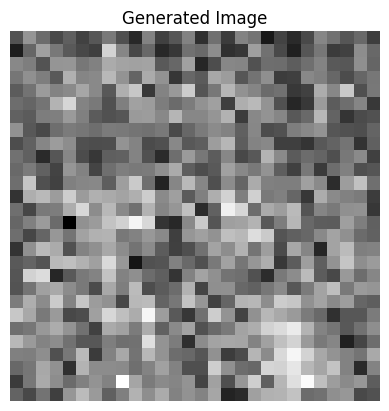

In [249]:
model = SimpleScoreModel(input_channels=channels, output_channels=channels, time_emb_dim=time_emb_dim, time_dim=time_dim).to(device)

generated_image = generate_with_noiser(
    size=batch_size,
    noiser=model,
    beta=beta,
    alpha_bar=alpha_bar,
    timesteps=timesteps,
    alpha=alpha,
    device=device
)

generated_image = generated_image.cpu().detach().numpy().reshape(batch_size, image_size, image_size)

plt.imshow(generated_image[0], cmap='gray')
plt.title('Generated Image')
plt.axis('off')
plt.show()